In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'nio' # ticker symbol
train = 1 # 1 for train, 0 for pass
days_ahead = 1 # for predicting 1 day ahead
cv = 5 # number of cross validation folds
model_name = 'Random Forest Classifier' # for display on charts, not a tuning parameter

In [3]:
# Extract, Transform, Load, and Train Test Split
# Dictionary of IPO Dates
start_dates = {'aapl':'12/12/1980' # Updated 1/1/21
               , 'acy': '01/18/1998' # Updated 1/1/21
               , 'amd': '03/17/1980' # Updated 1/1/21
               , 'baba': '09/15/2014' # Updated 1/1/21
               , 'bac': '02/19/1973' # Updated 1/1/21
               , 'crm': '06/23/2004' # Updated 1/1/21
               , 'esgv': '09/16/2018' # Updated 1/1/21
               , 'goog': '08/16/2004' # Updated 1/1/21
               , 'ibm': '01/02/1962' # Updated 1/1/21
               , 'idex': '05/23/2007' # Updated 1/1/21
               , 'intc': '03/16/1980' # Updated 1/1/21
               , 'iyw': '05/15/2000' # Updated 1/1/21
               , 'ma': '05/21/2006' # Updated 1/1/21
               , 'msft': '03/10/1986' # Updated 1/1/21
               , 'nio': '09/10/2018' # Updated 1/1/21
               , 'nvda': '01/22/1999'
               , 'pypl': '07/05/2015'
               , 'tsla': '06/29/2010'
               , 'v': '03/16/2008'
               , 'vbiv': '09/04/2002'
               , 'vgt': '01/26/2004'
              }
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-17,46.049999,43.900002,45.169998,46.000000,130003700,46.000000,-0.018375,0.048975,0.029774,0.052415,0.004539,-1
2020-12-18,48.000000,45.520000,45.889999,46.720001,126251100,46.720001,-0.018087,0.054482,0.015652,0.030757,0.021999,1
2020-12-21,49.490002,45.020000,45.630001,48.950001,132558100,48.950001,-0.072759,0.099289,0.047731,0.018185,0.036309,-1
2020-12-22,49.840000,46.529999,49.610001,47.580002,117118300,47.580002,0.040919,0.071137,-0.027988,0.028378,0.018413,1
2020-12-23,48.360001,45.810001,47.480000,47.009998,81247900,47.009998,0.009899,0.055665,-0.011980,0.030703,0.010638,-1
2020-12-24,47.130001,45.349998,46.880001,45.770000,60582500,45.770000,0.023677,0.039250,-0.026377,0.032187,-0.000592,-1
2020-12-28,46.849998,43.669998,46.669998,44.060001,105078000,44.060001,0.055925,0.072819,-0.037361,0.034169,-0.011195,1
2020-12-29,46.279999,42.230000,43.700001,46.139999,120689900,46.139999,-0.055835,0.095903,0.047208,0.033944,-0.011299,1
2020-12-30,48.380001,45.720001,46.500000,48.380001,116691700,48.380001,-0.040430,0.058180,0.048548,0.041050,0.004008,-1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
if train == 1:
    a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)
elif train == 0:
    pass

/home/david/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.67262515 0.67262515 0.67262515]
  warnings.warn(


In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

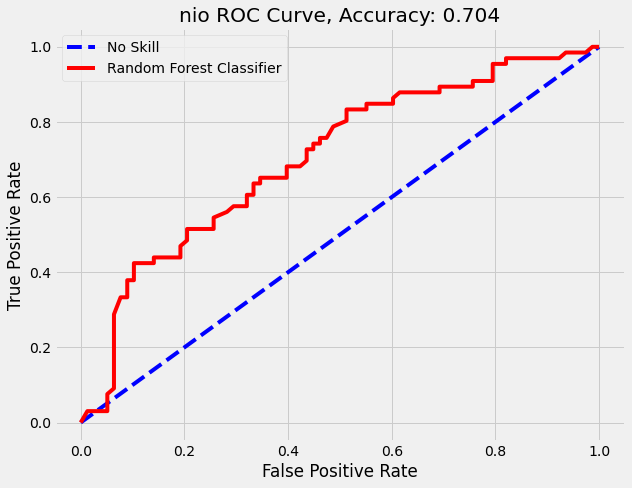

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

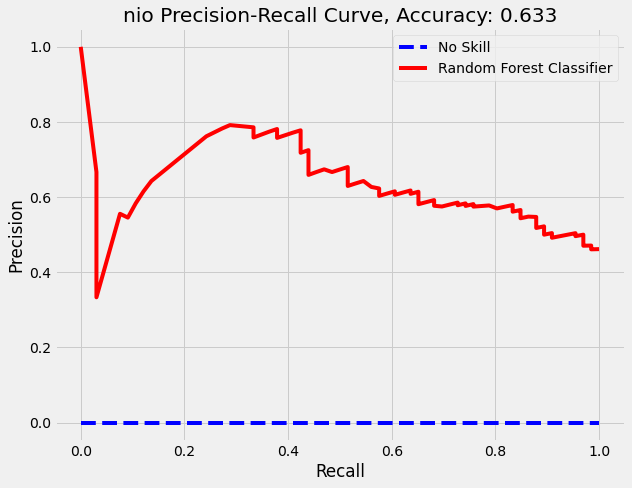

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

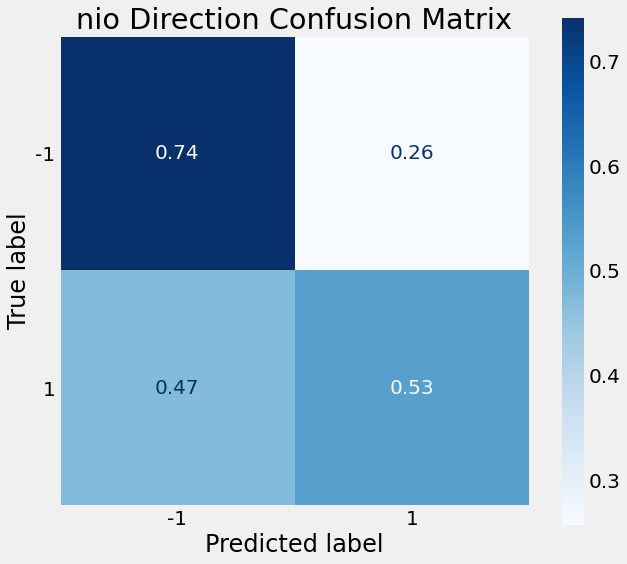

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.6336431784107945'

### Prediction...

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High          5.050000e+01
Low           4.777000e+01
Open          4.846000e+01
Close         4.874000e+01
Volume        1.291246e+08
Adj Close     4.874000e+01
oc           -5.778015e-03
hl            5.714883e-02
adj           7.441104e-03
5stdev_adj    4.006580e-02
5sma_adj      7.891865e-03
direction    -1.000000e+00
Name: 2020-12-31 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-1]
last

oc           -0.005778
hl            0.057149
5stdev_adj    0.040066
5sma_adj      0.007892
Name: 2020-12-31 00:00:00, dtype: float64

In [13]:
stock_df['adj'].describe()

count    576.000000
mean       0.005141
std        0.063889
min       -0.211614
25%       -0.031333
50%        0.000000
75%        0.032870
max        0.537190
Name: adj, dtype: float64

In [14]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name}')
else:
    print(f'Sell or hold {stock_name}')

Sell or hold nio


### Strategy Returns...

In [15]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [16]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-24,47.130001,45.349998,46.880001,45.770000,60582500,45.770000,0.023677,0.039250,-0.026377,0.032187,-0.000592,-1,1,-0.037361
2020-12-28,46.849998,43.669998,46.669998,44.060001,105078000,44.060001,0.055925,0.072819,-0.037361,0.034169,-0.011195,1,1,0.047208
2020-12-29,46.279999,42.230000,43.700001,46.139999,120689900,46.139999,-0.055835,0.095903,0.047208,0.033944,-0.011299,1,-1,-0.048548
2020-12-30,48.380001,45.720001,46.500000,48.380001,116691700,48.380001,-0.040430,0.058180,0.048548,0.041050,0.004008,-1,-1,-0.007441
2020-12-31,50.500000,47.770000,48.459999,48.740002,129124600,48.740002,-0.005778,0.057149,0.007441,0.040066,0.007892,-1,-1,-0.000000


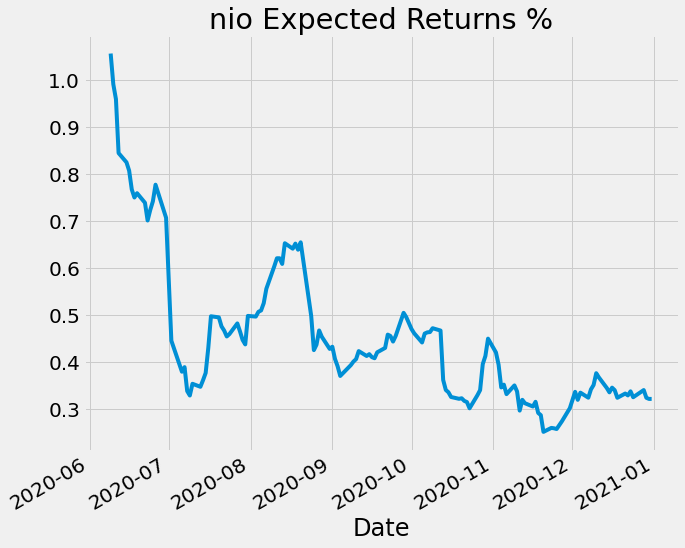

In [17]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [18]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

1.9186760936298437

In [19]:
# multiple times original investment, not bad but...

In [20]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) /stock_df['Close'][-test_idx]

9.618736396116821

In [21]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/